In [432]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
%matplotlib inline

In [176]:
data = pd.read_csv('kc_house_data.csv')

In [177]:
data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [178]:
# Let's see what data we're working with...

data.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [239]:
# making a smaller dataframe for poking and prodding
df = data
df = df.drop(columns = ['date', 'zipcode', 'lat', 'long'])

In [214]:
# Now we search for outliers

df.max()

id               9900000190
price               7.7e+06
bedrooms                 33
bathrooms                 8
sqft_living           13540
sqft_lot            1651359
floors                  3.5
waterfront                1
view                      4
condition                 5
grade                    13
sqft_above             9410
sqft_basement             ?
yr_built               2015
yr_renovated           2015
sqft_living15          6210
sqft_lot15           871200
dtype: object

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a2b05d470>,
      dtype=object)

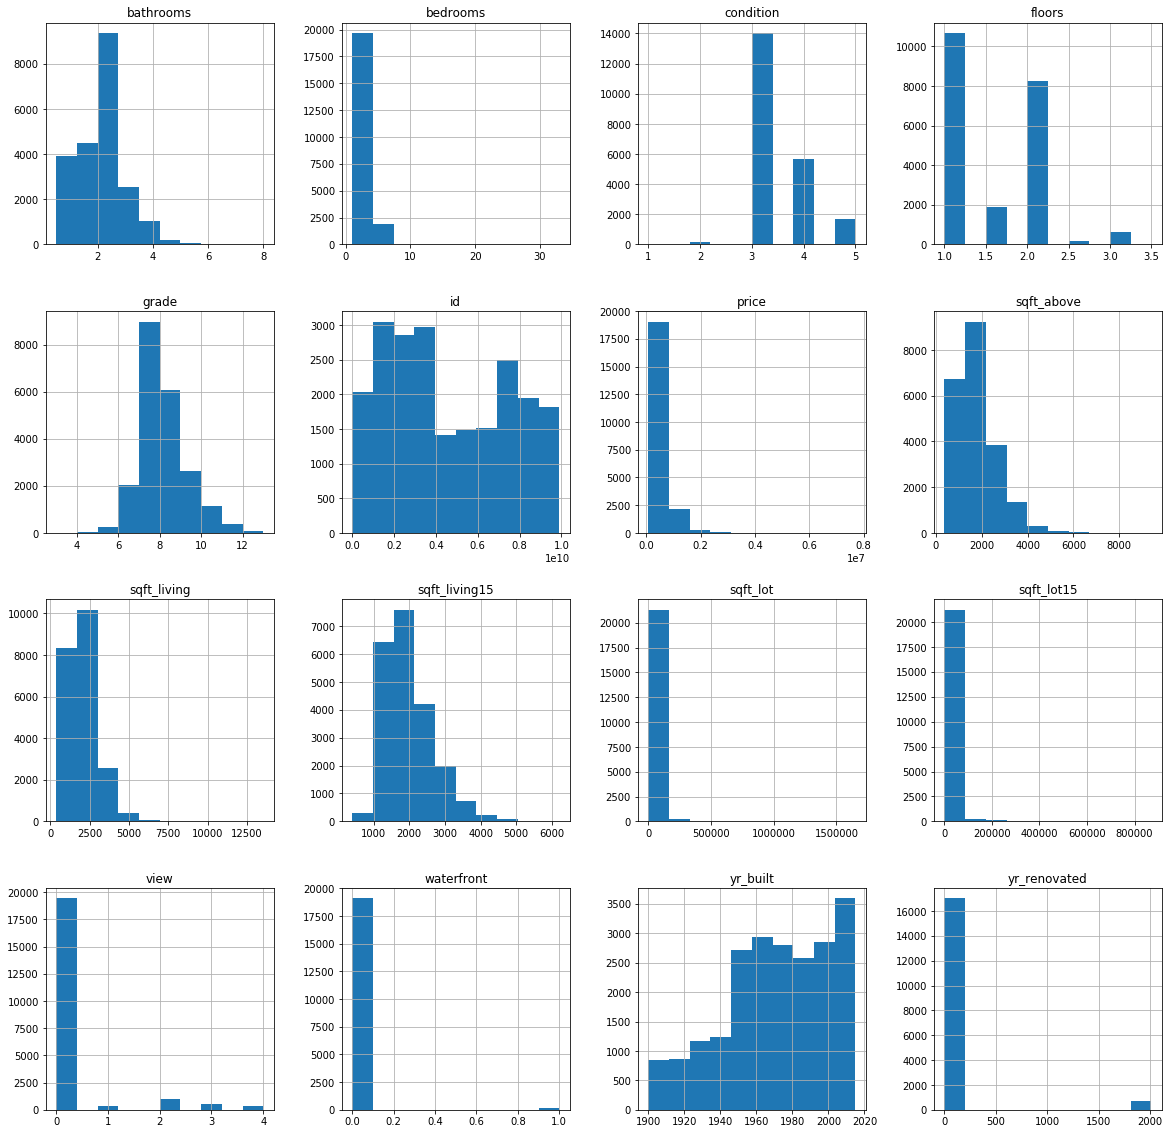

In [243]:
df.hist(figsize = (20,20))

In [260]:
# Looks like the view of 0 is pretty dominating. Here's the percentage with a view of 0.
round(((df['view'] == 0).sum()) / len(df['view']), 3)

0.899

In [261]:
# Same with waterfront.
round(((df['waterfront'] == 0).sum()) / len(df['waterfront']), 3)

0.883

In [263]:
# Before I jettison these two into space, I'm curious if the mean price is different for these locations.

In [280]:
df1 = df[df['waterfront'] > 0]
df2 = df[df['view'] > 0]
df3 = df[df['yr_renovated'] > 0]

In [292]:
# comparing the mean values of the price of the data sets where view or waterfrom != 0 is illuminating

print(round(df1['price'].mean()))
print(round(df2['price'].mean()))
print(round(df['price'].mean()))
print(round(df3['price'].mean()))

# Maybe I will keep them? For the moment I'm not getting rid of them.
# I'll revisit this later

1717215
937800
540297
768902


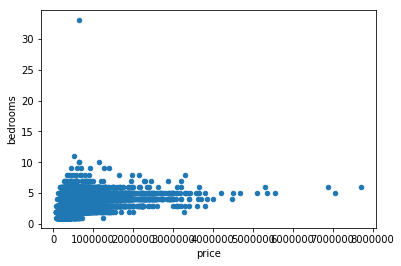

In [296]:
df.plot(x = 'price', y = 'bedrooms', kind='scatter')

In [297]:
# oh, what's up insane bedroom number? Let's get rid of you.
df.loc[df['bedrooms'] == 33]

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,sqft_living15,sqft_lot15
15856,2402100895,640000.0,33,1.75,1620,6000,1.0,0.0,0.0,5,7,1040,580.0,1947,0.0,1330,4700


In [304]:
# bye bye!
df = df.drop(df.index[15856])

In [306]:
df.loc[df['bedrooms'] == 33]

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,sqft_living15,sqft_lot15


In [313]:
df.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,yr_renovated,sqft_living15,sqft_lot15
count,2.159600e+04,2.159600e+04,21596.000000,21596.000000,21596.000000,2.159600e+04,21596.000000,19220.000000,21533.000000,21596.000000,21596.000000,21596.000000,21596.000000,17754.000000,21596.000000,21596.000000
mean,4.580575e+09,5.402920e+05,3.371828,2.115843,2080.343165,1.509983e+04,1.494119,0.007596,0.233874,3.409752,7.657946,1788.631506,1971.000787,83.641489,1986.650722,12758.656649
std,2.876764e+09,3.673760e+05,0.904114,0.768998,918.122038,4.141355e+04,0.539685,0.086827,0.765702,0.650471,1.173218,827.763251,29.375460,399.957185,685.231768,27275.018316
min,1.000102e+06,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,3.000000,370.000000,1900.000000,0.000000,399.000000,651.000000
25%,2.123049e+09,3.220000e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,1951.000000,0.000000,1490.000000,5100.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.619000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,1975.000000,0.000000,1840.000000,7620.000000
75%,7.308950e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068550e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,1997.000000,0.000000,2360.000000,10083.000000
max,9.900000e+09,7.700000e+06,11.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,2015.000000,2015.000000,6210.000000,871200.000000


In [322]:
bedroom_95 = df['bedrooms'].std() * 3
bedroom_95

2.712341188449809

In [336]:
df[df['bedrooms'] < bedroom_95].count()

id               2956
price            2956
bedrooms         2956
bathrooms        2956
sqft_living      2956
sqft_lot         2956
floors           2956
waterfront       2626
view             2950
condition        2956
grade            2956
sqft_above       2956
sqft_basement    2956
yr_built         2956
yr_renovated     2412
sqft_living15    2956
sqft_lot15       2956
dtype: int64

In [452]:
df_95 = df

In [453]:
df_95.head()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,sqft_living15,sqft_lot15
0,7129300520,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,3,7,1180,0.0,1955,0.0,1340,5650
1,6414100192,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,7,2170,400.0,1951,1991.0,1690,7639
2,5631500400,180000.0,2,1.00,770,10000,1.0,0.0,0.0,3,6,770,0.0,1933,NaN,2720,8062
3,2487200875,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,7,1050,910.0,1965,0.0,1360,5000
4,1954400510,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,8,1680,0.0,1987,0.0,1800,7503


In [454]:
df_95 = df[(df['price'] < df['price'].std() * 3)
           & (df['bedrooms'] < df['bedrooms'].std() * 3)
           & (df['bathrooms'] < df['bathrooms'].std() * 3)
           & (df['sqft_living'] < df['sqft_living'].std() * 3)
           & (df['sqft_lot'] < df['sqft_lot'].std() * 3)
           & (df['sqft_lot15'] < df['sqft_lot15'].std() * 3)
           & (df['sqft_living15'] < df['sqft_living15'].std() * 3)]

In [397]:
df_95.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,yr_renovated,sqft_living15,sqft_lot15
count,2.439000e+03,2439.000000,2439.000000,2439.000000,2439.000000,2439.000000,2439.000000,2171.000000,2433.000000,2439.000000,2439.000000,2439.000000,2439.000000,1988.000000,2439.000000,2439.000000
mean,4.664261e+09,363533.749487,1.929479,1.258610,1118.672407,6850.110291,1.238417,0.007370,0.104809,3.382534,6.671587,1009.892169,1950.602706,87.953722,1385.322263,6487.267733
std,2.868942e+09,145510.817266,0.256075,0.405026,346.921158,8298.086625,0.484421,0.085551,0.509076,0.678419,0.862095,275.185686,30.845177,408.809124,283.035924,6195.429004
min,7.200179e+06,78000.000000,1.000000,0.500000,370.000000,600.000000,1.000000,0.000000,0.000000,1.000000,3.000000,370.000000,1900.000000,0.000000,460.000000,659.000000
25%,2.194601e+09,250137.500000,2.000000,1.000000,860.000000,3699.000000,1.000000,0.000000,0.000000,3.000000,6.000000,820.000000,1926.000000,0.000000,1180.000000,4000.000000
50%,4.008401e+09,347000.000000,2.000000,1.000000,1060.000000,5185.000000,1.000000,0.000000,0.000000,3.000000,7.000000,960.000000,1947.000000,0.000000,1370.000000,5289.000000
75%,7.444000e+09,450250.000000,2.000000,1.500000,1310.000000,7552.000000,1.000000,0.000000,0.000000,4.000000,7.000000,1150.000000,1966.000000,0.000000,1570.000000,7500.000000
max,9.895000e+09,998500.000000,2.000000,2.250000,2730.000000,113862.000000,3.000000,1.000000,4.000000,5.000000,10.000000,2320.000000,2015.000000,2014.000000,2054.000000,80201.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10c61b438>,
      dtype=object)

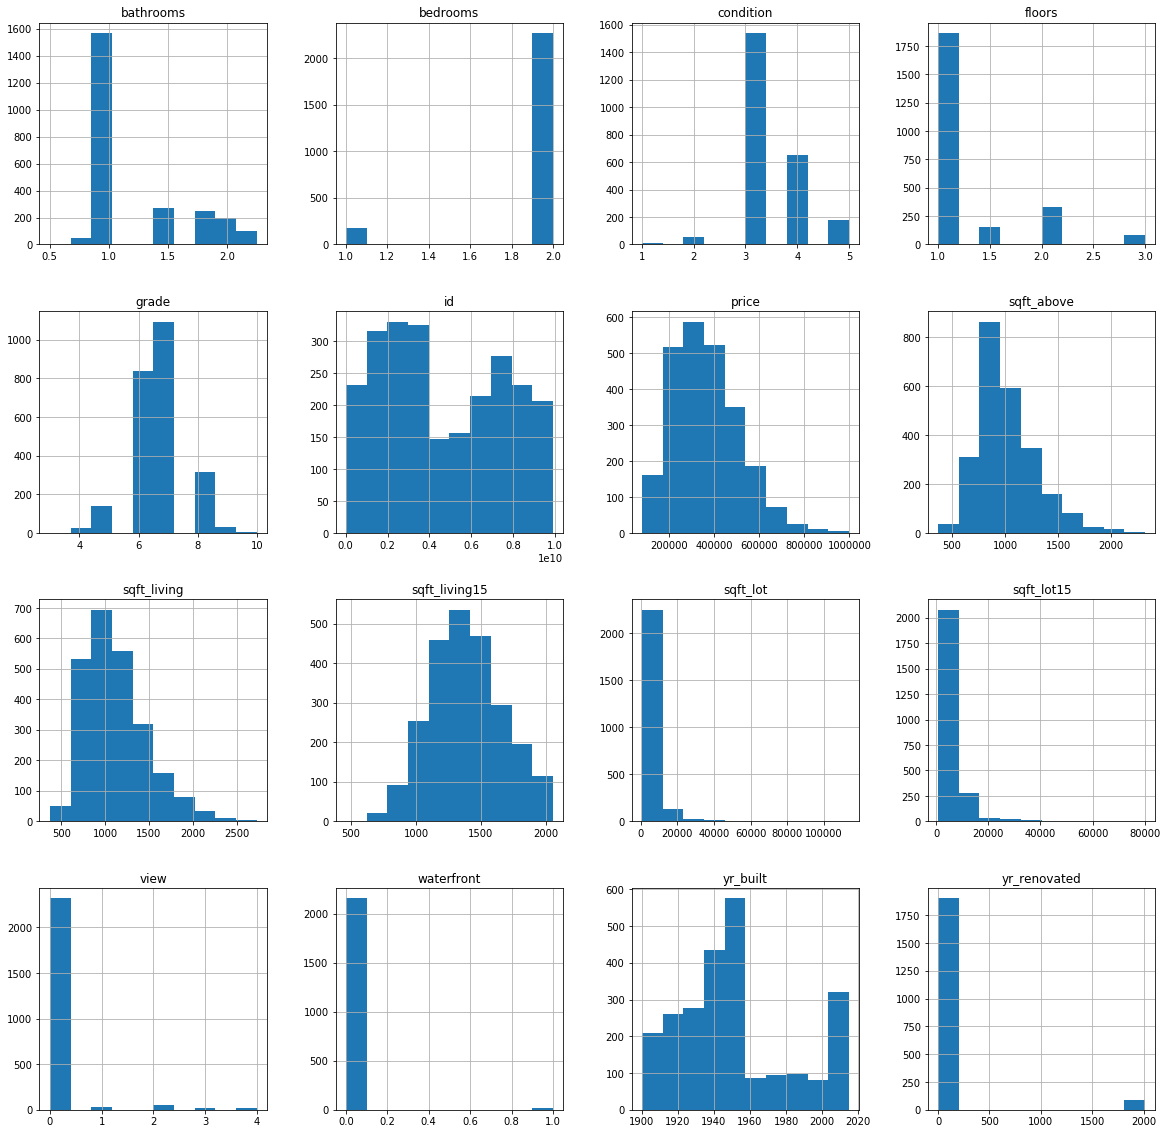

In [398]:
df_95.hist(figsize = (20,20))

In [367]:
abs(df_95.corr() > 0.75)

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,yr_renovated,sqft_living15,sqft_lot15
id,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
price,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
bedrooms,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
bathrooms,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
sqft_living,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False
sqft_lot,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True
floors,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False
waterfront,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False
view,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False
condition,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False


In [368]:
df_95.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,yr_renovated,sqft_living15,sqft_lot15
count,2.634000e+03,2.634000e+03,2634.000000,2634.000000,2634.000000,2634.000000,2634.000000,2341.000000,2628.000000,2634.000000,2634.000000,2634.000000,2634.000000,2145.000000,2634.000000,2634.000000
mean,4.618772e+09,3.747962e+05,1.929765,1.267369,1144.837509,7433.797267,1.232916,0.008116,0.146119,3.389522,6.701974,1029.623766,1950.516325,90.774825,1458.627563,6865.113895
std,2.864691e+09,1.564246e+05,0.255592,0.408276,369.987623,9790.686575,0.475314,0.089743,0.598148,0.678561,0.877418,294.691796,30.409097,414.985136,384.109714,6856.677076
min,7.200179e+06,7.800000e+04,1.000000,0.500000,370.000000,600.000000,1.000000,0.000000,0.000000,1.000000,3.000000,370.000000,1900.000000,0.000000,460.000000,659.000000
25%,2.139950e+09,2.550000e+05,2.000000,1.000000,870.000000,3835.000000,1.000000,0.000000,0.000000,3.000000,6.000000,830.000000,1926.000000,0.000000,1200.000000,4000.000000
50%,3.971701e+09,3.540000e+05,2.000000,1.000000,1070.000000,5336.000000,1.000000,0.000000,0.000000,3.000000,7.000000,970.000000,1947.000000,0.000000,1400.000000,5413.000000
75%,7.332926e+09,4.628875e+05,2.000000,1.500000,1340.000000,7740.000000,1.000000,0.000000,0.000000,4.000000,7.000000,1170.000000,1964.000000,0.000000,1650.000000,7629.250000
max,9.895000e+09,1.100000e+06,2.000000,2.250000,2730.000000,119790.000000,3.000000,1.000000,4.000000,5.000000,10.000000,2510.000000,2015.000000,2014.000000,3360.000000,80201.000000


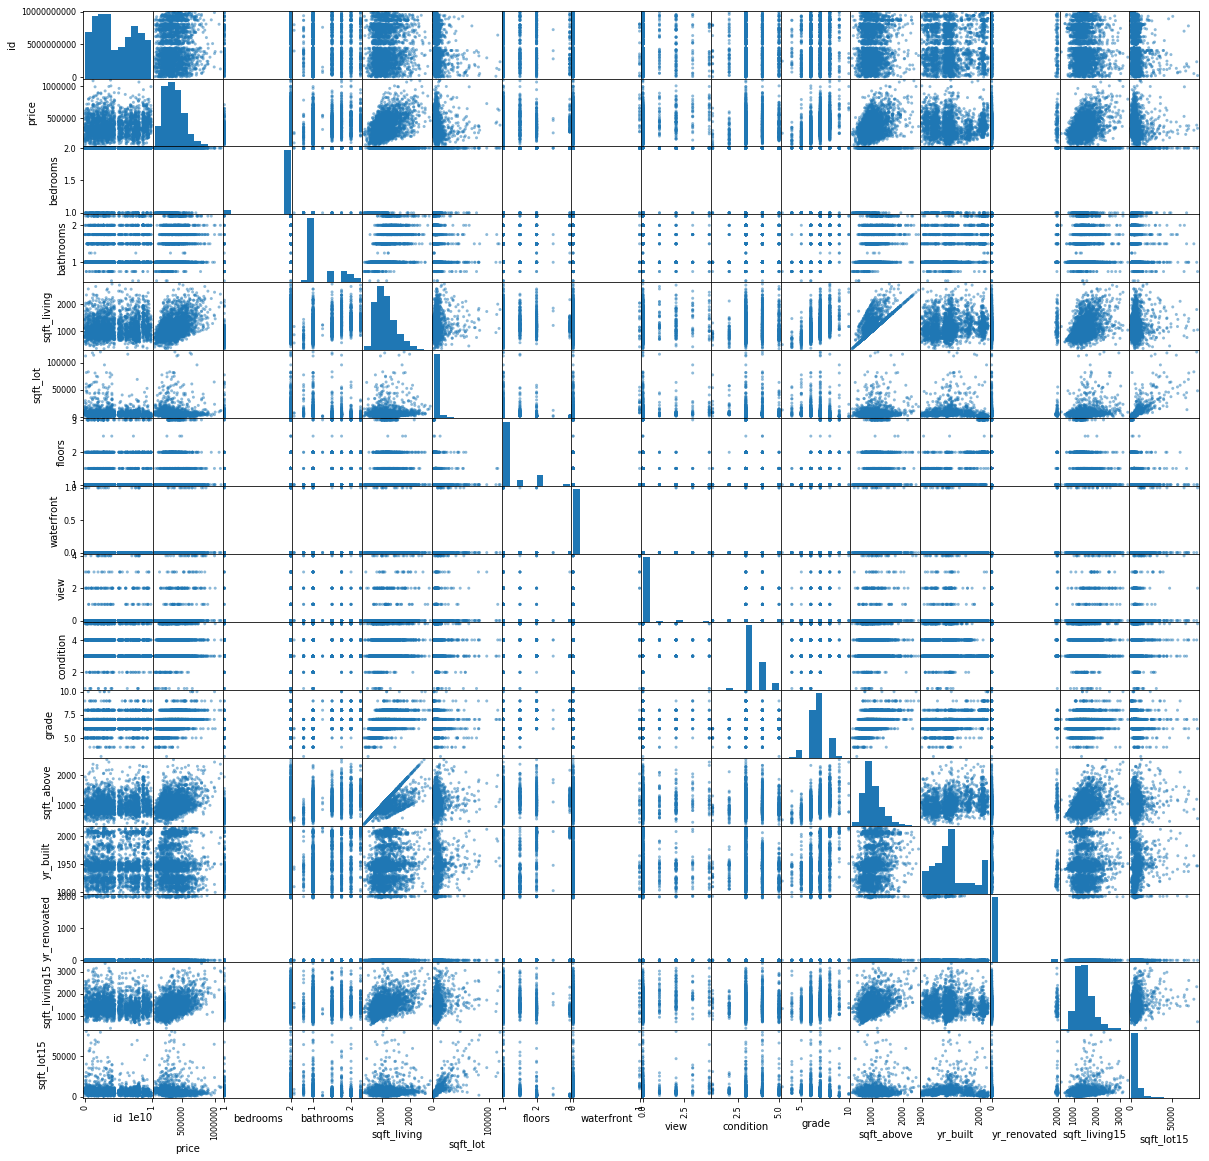

In [395]:
pd.plotting.scatter_matrix(df_95,figsize  = [20, 20]);

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a3a7250b8>,
      dtype=object)

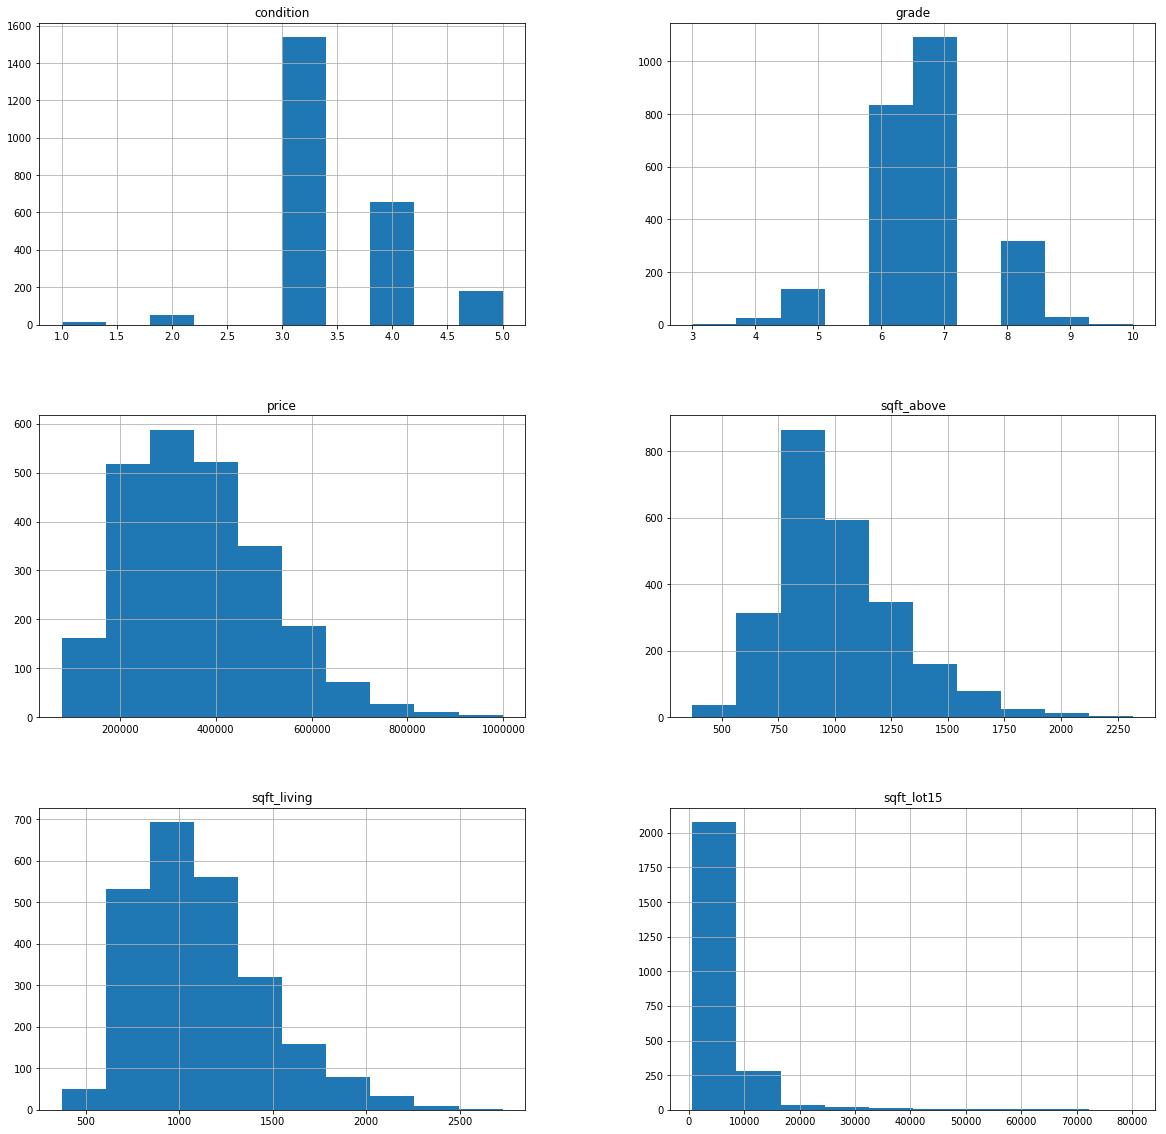

In [405]:
df_95.hist(column=['price', 'sqft_living', 'grade', 'condition', 'sqft_above', 'sqft_lot15'], figsize = (20,20))

In [413]:
def calc_slope(xs,ys):
    
    m = (((np.mean(xs)*np.mean(ys)) - np.mean(xs*ys)) /
         ((np.mean(xs)**2) - np.mean(xs*xs)))
    
    return m

calc_slope(df['sqft_above'],df['price'])


268.6836261721955

In [415]:
def best_fit(xs,ys):
    
    # use the slope function with intercept formula to return calculate slope and intercept from data points
    m = calc_slope(xs,ys)
    c = np.mean(ys) - m*np.mean(xs)
    
    return m, c

m, c = best_fit(df['sqft_above'],df['price'])
m, c


(268.6836261721955, 59715.95787782548)

In [416]:
def reg_line (m, c, xs):
    
    return [(m*x)+c for x in xs]

regression_line = reg_line(268.6836261721955,59715.95787782548,df['sqft_above'])

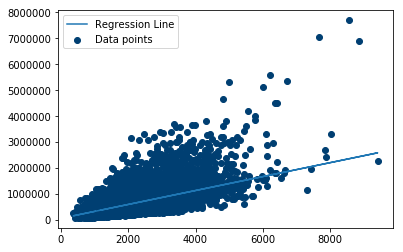

In [426]:
plt.scatter(df['sqft_above'],df['price'],color='#003F72', label="Data points")
plt.plot(df['sqft_above'], regression_line, label= "Regression Line")
plt.legend()
plt.show()

In [446]:
# build the formula 
f = 'price~grade+floors+condition'
# create a fitted model in one line
model = smf.ols(formula=f, data=df_95).fit()


In [447]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.212
Model:                            OLS   Adj. R-squared:                  0.211
Method:                 Least Squares   F-statistic:                     218.1
Date:                Mon, 06 May 2019   Prob (F-statistic):          2.67e-125
Time:                        14:25:41   Log-Likelihood:                -32165.
No. Observations:                2439   AIC:                         6.434e+04
Df Residuals:                    2435   BIC:                         6.436e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -2.797e+05   2.73e+04    -10.259      0.000   -3.33e+05   -2.26e+05
grade        9.46e+05   3.89e+04     24.327      0.000     8.7e+05    1.02e+06
floors     -1.665e+04   5945.053     -2.801      0.005   -2.83e+04   -4994.109
condition   1.906e+04   3913.863      4.870      0.000    1.14e+04    2.67e+04
==============================================================================
Omnibus:                      227.536   Durbin-Watson:                   1.956
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              335.401
Skew:                           0.714   Prob(JB):                     1.47e-73
Kurtosis:                       4.122   Cond. No.                         66.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [455]:
outcome = 'price'
x_cols = ['condition', 'grade', 'sqft_above', 'sqft_lot15']
predictors = '+'.join(x_cols)
formula = outcome + "~" + predictors
model = ols(formula=formula, data=data).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.492
Model:                            OLS   Adj. R-squared:                  0.492
Method:                 Least Squares   F-statistic:                     5230.
Date:                Mon, 06 May 2019   Prob (F-statistic):               0.00
Time:                        14:33:15   Log-Likelihood:            -3.0008e+05
No. Observations:               21597   AIC:                         6.002e+05
Df Residuals:                   21592   BIC:                         6.002e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1.144e+06   1.76e+04    -65.104      0.000   -1.18e+06   -1.11e+06
condition   8.478e+04   2777.487     30.526      0.000    7.93e+04    9.02e+04
grade       1.561e+05   2324.308     67.161      0.000    1.52e+05    1.61e+05
sqft_above   114.3368      3.341     34.218      0.000     107.787     120.886
sqft_lot15    -0.3671      0.067     -5.505      0.000      -0.498      -0.236
==============================================================================
Omnibus:                    18854.953   Durbin-Watson:                   1.983
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1605374.794
Skew:                           3.794   Prob(JB):                         0.00
Kurtosis:                      44.550   Cond. No.                     3.00e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large,  3e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

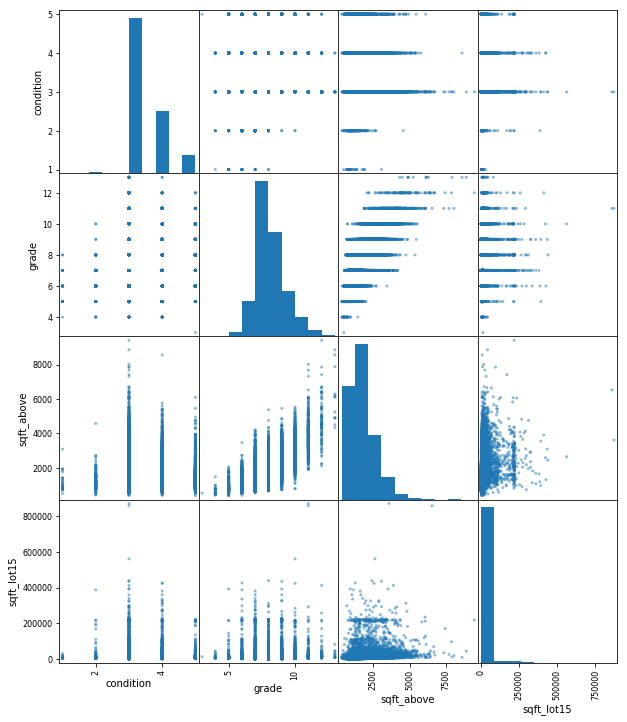

In [456]:
pd.plotting.scatter_matrix(data[x_cols], figsize=(10,12));

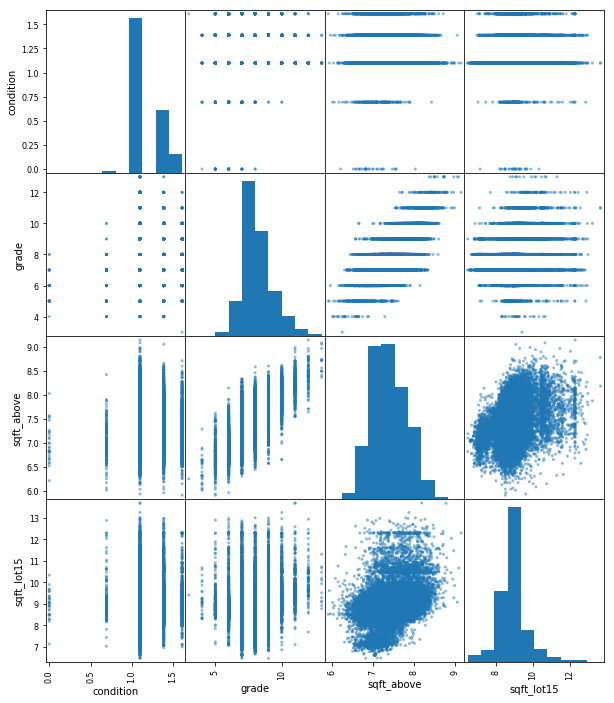

In [457]:
non_normal = ['condition', 'sqft_above', 'sqft_lot15']
for feat in non_normal:
    data[feat] = data[feat].map(lambda x: np.log(x))
pd.plotting.scatter_matrix(data[x_cols], figsize=(10,12));

In [459]:
outcome = 'price'
x_cols = ['condition', 'grade', 'sqft_above', 'sqft_lot15']
predictors = '+'.join(x_cols)
formula = outcome + "~" + predictors
model = ols(formula=formula, data=data).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.468
Model:                            OLS   Adj. R-squared:                  0.468
Method:                 Least Squares   F-statistic:                     4754.
Date:                Mon, 06 May 2019   Prob (F-statistic):               0.00
Time:                        14:34:40   Log-Likelihood:            -3.0057e+05
No. Observations:               21597   AIC:                         6.011e+05
Df Residuals:                   21592   BIC:                         6.012e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1.944e+06   4.03e+04    -48.309      0.000   -2.02e+06   -1.87e+06
condition   2.714e+05   1.02e+04     26.474      0.000    2.51e+05    2.91e+05
grade       1.876e+05   2326.678     80.610      0.000    1.83e+05    1.92e+05
sqft_above  1.025e+05   6603.493     15.525      0.000    8.96e+04    1.15e+05
sqft_lot15 -4232.6109   2374.073     -1.783      0.075   -8885.968     420.747
==============================================================================
Omnibus:                    20161.882   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          2208583.808
Skew:                           4.158   Prob(JB):                         0.00
Kurtosis:                      51.838   Cond. No.                         314.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""